## Predicao_energia_eletrica_SE_CO

### Libraries_input

In [457]:
! pip install lightgbm
! pip install xgboost

In [458]:
import pandas as pd
import numpy as np
import datetime
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from sklearn.preprocessing import Normalizer
from sklearn import preprocessing
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
from sklearn.metrics import r2_score 
from sklearn.metrics import mean_squared_error # MSE
from sklearn.metrics import mean_absolute_error
import numpy as np
from sklearn.metrics import mean_squared_log_error
import re

## Functions_def

In [460]:
# data substitution
def data_replace(df):
    for a in df.columns:
        z = df[a].median()
        print(a,z)
        b =-999.0
        df[a] = df[a].replace(b,z)
    return df

In [461]:
# MAPE function
def MAPE(a,b):
    z = (abs(a-b)/a)*100
    return z

In [462]:
# R2 ajustado -- ponderação entre os fatores mais relevantes
def adjusted_r2(y_test, y_rf,x_train):
    from sklearn.metrics import r2_score
    adj_r2 = (1 - ((1 - r2_score(y_test, y_rf)) * (len(y_test) - 1)) / 
          (len(y_test) - x_train.shape[1] - 1))
    return adj_r2
#a= round(adjusted_r2(y_test,y_rf,x_train),3)
#print(a)

In [463]:
def perform (a,b):
    w = pd.DataFrame()
    # a = true_value
    # b = forecast_value
    w['true'] = a
    w['pred'] = b
    w['R2'] = r2_score(w['true'],w['pred'])
    w['MSE'] = mean_squared_error(w['true'],w['pred'])
    w['RMSE'] = w['MSE']**0.5
    w['MAE'] =  mean_absolute_error(w['true'],w['pred'])
    w['MAPE'] = (abs(w['true']-w['pred'])/w['true'])*100
    # msle_rf = mean_squared_log_error(y_test,y_rf)
    return w
# print('MSLE =', round(msle_rf,3))

## Data_input

In [465]:
df = pd.read_csv(r'SE_CO_clean.csv', sep = ',')
df = df[['Timestamp','MWh']]
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['ano'] = df['Timestamp'].dt.year
df['mes'] = df['Timestamp'].dt.month
df['dia'] = df['Timestamp'].dt.day

In [466]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1349 entries, 0 to 1348
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Timestamp  1349 non-null   datetime64[ns]
 1   MWh        1349 non-null   float64       
 2   ano        1349 non-null   int32         
 3   mes        1349 non-null   int32         
 4   dia        1349 non-null   int32         
dtypes: datetime64[ns](1), float64(1), int32(3)
memory usage: 37.0 KB


## Data_treatment

In [468]:
df = data_replace(df)
df.tail(3)

Timestamp 2022-11-06 00:00:00
MWh 40658.6
ano 2022.0
mes 6.0
dia 16.0


,Timestamp,MWh,ano,mes,dia
1346,2024-08-09,40251.7,2024,8,9
1347,2024-09-09,47135.2,2024,9,9
1348,2024-10-09,47788.8,2024,10,9


In [469]:
df.isna().value_counts()

Timestamp  MWh    ano    mes    dia  
False      False  False  False  False    1349
Name: count, dtype: int64

In [470]:
df = df.fillna(df.median())

In [471]:
a = (3*len(df))//4
a # train_test_threshold = 75% daily_aggregation

1011

In [472]:
X_train = df.iloc[0:a,2:5] # first 1011 days
X_train = pd.DataFrame(X_train)
X_test = df.iloc[a:,2:5] # l
X_test = pd.DataFrame(X_test)
y_train = df.iloc[0:a,1]
y_train = np.array(y_train)
# y_train = pd.DataFrame(y_train)                    
y_test = df.iloc[a:,1] 
y_test = np.array(y_test)
# y_test = pd.DataFrame(y_test)

## Data_input_preprocessing

## Feature_importance_first_check

In [475]:
from sklearn.ensemble import ExtraTreesRegressor
model = ExtraTreesRegressor(n_estimators= 7)
model.fit(X_train, y_train) # mostra_inicial_hiperparametros

ExtraTreesRegressor(n_estimators=7)

In [476]:
print(model.feature_importances_)
# relevant_explaining_variables

[0.05218749 0.37222331 0.5755892 ]


<Axes: >

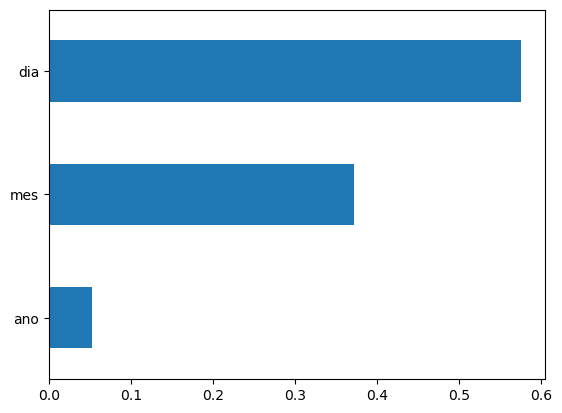

In [477]:
(pd.Series(model.feature_importances_, index = X_train.columns)
   .nlargest(6).sort_values().plot.barh())

## First_forecast_ML_DT_method_Random_Forest

In [479]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)
print('parameters_in_use:\n')
pprint(rf.get_params())

parameters_in_use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [480]:
params_grid= {'n_estimators':[2,3,4,5,6,7,8,9,10,11,12],
              "max_features":['sqrt', 'log2'],
              'max_depth':[5,10,20,30],
              'max_leaf_nodes':[2,3,4,5],
              'min_samples_leaf':[5,10,15],
              'min_samples_split':[3,6,9,12,15,18,21]}
random_rf = RandomizedSearchCV(estimator = rf,cv=10,param_distributions=params_grid,n_iter=100,verbose=2,n_jobs=-1)
random_rf.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 20, 30],
                                        'max_features': ['sqrt', 'log2'],
                                        'max_leaf_nodes': [2, 3, 4, 5],
                                        'min_samples_leaf': [5, 10, 15],
                                        'min_samples_split': [3, 6, 9, 12, 15,
                                                              18, 21],
                                        'n_estimators': [2, 3, 4, 5, 6, 7, 8, 9,
                                                         10, 11, 12]},
                   verbose=2)

In [481]:
random_rf.best_params_

{'n_estimators': 7,
 'min_samples_split': 18,
 'min_samples_leaf': 15,
 'max_leaf_nodes': 5,
 'max_features': 'log2',
 'max_depth': 20}

In [482]:
m_rf = RandomForestRegressor(n_estimators = 6,
 min_samples_split = 9,
 min_samples_leaf = 5,
 max_leaf_nodes = 5,
 max_features = 'log2',
 max_depth = 20)

#### Random_Forest_application

In [484]:
yrf = m_rf.fit(X_train,y_train)
print(yrf)

RandomForestRegressor(max_depth=20, max_features='log2', max_leaf_nodes=5,
                      min_samples_leaf=5, min_samples_split=9, n_estimators=6)


In [485]:
y_rf= yrf.predict(X_test)

In [486]:
c = np.mean(y_train)
print(round(c,3))

39790.747


#### Random_Forest_score

In [488]:
RF = round(perform(y_test, y_rf),3)

In [489]:
mean = RF['true'].mean()
RF['Mean_pred_ratio'] = round((abs(mean - RF['pred'])/mean)*100,3)
mean_MAPE = RF['MAPE'].mean()
mean_ratio = RF['Mean_pred_ratio'].mean()
RF.tail(5)

,true,pred,R2,MSE,RMSE,MAE,MAPE,Mean_pred_ratio
333,46038.8,40485.738,-0.819,2.960119e+07,5440.698,4576.337,12.062,9.156
334,41715.5,40485.738,-0.819,2.960119e+07,5440.698,4576.337,2.948,9.156
335,40251.7,40485.738,-0.819,2.960119e+07,5440.698,4576.337,0.581,9.156
336,47135.2,41457.167,-0.819,2.960119e+07,5440.698,4576.337,12.046,6.976
337,47788.8,40876.730,-0.819,2.960119e+07,5440.698,4576.337,14.464,8.278


In [490]:
print('mean_MAPE =', round(mean_MAPE,3),'  ','mean_ratio =', round(mean_ratio,3))

mean_MAPE = 9.871    mean_ratio = 8.608


## Ensemble_Light & Xgboost_hyperparameters

In [492]:
# Light & XG Boosting
params_grid_g= {
    'booster': ["gbtree","gblinear",'dart'],
    'learning_rate': [0.05,0.1,0.2,0.3,0.4,0.5],
    'max_depth': [3,4,5,8,10,11,12],
    #'min_child_weigth': [1,3,5,7],
    'gamma': [0,0.1,0.2,0.3,0.4],
    'colsample_bytree': [0.3,0.4,0.5,0.6]
}

In [493]:
# X_train['Timestamp'] = X_train['Timestamp'].astype(str)

In [522]:
lgb = lgb.LGBMRegressor(learning_rate = 0.001,num_leaves = 65,n_estimators = 100)                       
lgb.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 49
[LightGBM] [Info] Number of data points in the train set: 1011, number of used features: 3
[LightGBM] [Info] Start training from score 39790.746890
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

LGBMRegressor(learning_rate=0.001, num_leaves=65)

In [524]:
random_search_lgb = RandomizedSearchCV(lgb,param_distributions=params_grid_g,n_iter=5,n_jobs=-1,cv=5,verbose=3)

## LGB_application

In [527]:
random_search_lgb.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 49
[LightGBM] [Info] Number of data points in the train set: 1011, number of used features: 3
[LightGBM] [Info] Start training from score 39790.746890
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

RandomizedSearchCV(cv=5,
                   estimator=LGBMRegressor(learning_rate=0.001, num_leaves=65),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'booster': ['gbtree', 'gblinear',
                                                    'dart'],
                                        'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.6],
                                        'gamma': [0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.2, 0.3,
                                                          0.4, 0.5],
                                        'max_depth': [3, 4, 5, 8, 10, 11, 12]},
                   verbose=3)

In [528]:
from sklearn.model_selection import cross_val_score
score_lgb = cross_val_score(lgb,X_train,y_train,cv=10, verbose = 0)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 49
[LightGBM] [Info] Number of data points in the train set: 909, number of used features: 3
[LightGBM] [Info] Start training from score 39662.169875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [533]:
print(random_search_lgb.best_estimator_)

LGBMRegressor(booster='gbtree', colsample_bytree=0.6, gamma=0.2,
              learning_rate=0.05, max_depth=11, num_leaves=65)


In [535]:
 m_lgb = LGBMRegressor(booster='gbtree', colsample_bytree=0.6, gamma=0.2,
                       learning_rate=0.05,
                       max_depth=11, min_child_weigth=3, num_leaves=65)

In [537]:
m_lgb.fit(X_train,y_train)

[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: min_child_weigth
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: min_child_weigth
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 49
[LightGBM] [Info] Number of data points in the train set: 1011, number of used features: 3
[LightGBM] [Info] Start training from score 39790.746890
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

LGBMRegressor(booster='gbtree', colsample_bytree=0.6, gamma=0.2,
              learning_rate=0.05, max_depth=11, min_child_weigth=3,
              num_leaves=65)

In [539]:
y_lgb = m_lgb.predict(X_test)

[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: min_child_weigth


In [541]:
LGB = round(perform(y_test, y_lgb),3)

In [543]:
mean = LGB['true'].mean()
LGB['Mean_pred_ratio'] = round((abs(mean - LGB['pred'])/mean)*100,3)
mean_MAPE = LGB['MAPE'].mean()
mean_ratio = LGB['Mean_pred_ratio'].mean()
LGB.tail(5)

,true,pred,R2,MSE,RMSE,MAE,MAPE,Mean_pred_ratio
333,46038.8,40415.693,-1.009,3.269678e+07,5718.11,4900.338,12.214,9.313
334,41715.5,39760.781,-1.009,3.269678e+07,5718.11,4900.338,4.686,10.782
335,40251.7,40069.026,-1.009,3.269678e+07,5718.11,4900.338,0.454,10.091
336,47135.2,41398.452,-1.009,3.269678e+07,5718.11,4900.338,12.171,7.108
337,47788.8,39664.900,-1.009,3.269678e+07,5718.11,4900.338,17.000,10.997


In [545]:
print('LGB_mean_MAPE =', round(mean_MAPE,3),'  ','LGB_mean_ratio =', round(mean_ratio,3))

LGB_mean_MAPE = 10.608    LGB_mean_ratio = 9.633


## Ensemble_XGBoost

In [548]:
xgb = XGBRegressor()
xgb_model = XGBRegressor(learning_rate = 0.001, max_depth = 8,n_estimators = 100)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [550]:
random_search_xgb = RandomizedSearchCV(xgb,param_distributions=params_grid_g,n_iter=5,n_jobs=-1,cv=5,verbose=0)

In [552]:
random_search_xgb.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'booster': ['gbtree', 'gblinear',
                                                    'dart'],
                                        'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.6],
                                        'gamma': [0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.2, 0.3,
                                                          0.4, 0.5],
                                        'max_depth': [3, 4, 5, 8, 10, 11, 12]})

In [554]:
print(random_search_xgb.best_estimator_)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.3, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)


In [556]:
m_xgb = XGBRegressor(base_score=None, booster='dart', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.3, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing= 0, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None)

#### Ensemble_XGBoost_application

In [559]:
m_xgb.fit(X_train,y_train)

XGBRegressor(base_score=None, booster='dart', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.3, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=0, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [561]:
y_xgb = m_xgb.predict(X_test)

In [563]:
XGB = round(perform(y_test, y_xgb),3)

In [565]:
mean = XGB['true'].mean()
XGB['Mean_pred_ratio'] = round((abs(mean - XGB['pred'])/mean)*100,3)
mean_MAPE = XGB['MAPE'].mean()
mean_ratio = XGB['Mean_pred_ratio'].mean()
XGB.tail(5)

,true,pred,R2,MSE,RMSE,MAE,MAPE,Mean_pred_ratio
333,46038.8,38885.332031,-0.798,2.926173e+07,5409.411,4605.396,15.538,12.747
334,41715.5,38865.738281,-0.798,2.926173e+07,5409.411,4605.396,6.831,12.791
335,40251.7,39655.703125,-0.798,2.926173e+07,5409.411,4605.396,1.481,11.018
336,47135.2,41218.328125,-0.798,2.926173e+07,5409.411,4605.396,12.553,7.512
337,47788.8,39994.593750,-0.798,2.926173e+07,5409.411,4605.396,16.310,10.258


In [567]:
print('XGB_mean_MAPE =', round(mean_MAPE,3),'  ','XGB_mean_ratio =', round(mean_ratio,3))

XGB_mean_MAPE = 9.967    XGB_mean_ratio = 8.757


## Ensemble_Gradient_Boosting

In [570]:
# Gradient Boosting
params0= {
    'min_samples_split': [300,400,500],
    'min_samples_leaf': [30,40,50],
    'min_weight_fraction_leaf': [0, 0.1, 0.2, 0.3, 0.4],
    'max_depth': [5,6,7,8],
    'subsample': [0.6,0.7,0.8],
    'learning_rate' : [0.001, 0.01, 0.09, 0.1, 0.15]
}

In [572]:
gbr = GradientBoostingRegressor(random_state=0)

gbr.fit(X_train, y_train)

GradientBoostingRegressor(random_state=0)

In [574]:
random_search_gbr = RandomizedSearchCV(gbr,param_distributions=params0,n_iter=5,n_jobs=-1,cv=5,verbose=3)

In [578]:
random_search_gbr.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=0),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'learning_rate': [0.001, 0.01, 0.09,
                                                          0.1, 0.15],
                                        'max_depth': [5, 6, 7, 8],
                                        'min_samples_leaf': [30, 40, 50],
                                        'min_samples_split': [300, 400, 500],
                                        'min_weight_fraction_leaf': [0, 0.1,
                                                                     0.2, 0.3,
                                                                     0.4],
                                        'subsample': [0.6, 0.7, 0.8]},
                   verbose=3)

In [582]:
from sklearn.model_selection import cross_val_score
score_gbr=cross_val_score(gbr,X_train,y_train,cv=10)
score_gbr

array([ 0.0028386 ,  0.01194972,  0.00911257,  0.13595639,  0.00147702,
       -0.15039215, -0.39425574,  0.16628503,  0.08462081, -0.32726841])

In [584]:
print(random_search_gbr.best_estimator_)

GradientBoostingRegressor(learning_rate=0.09, max_depth=8, min_samples_leaf=50,
                          min_samples_split=300, min_weight_fraction_leaf=0.1,
                          random_state=0, subsample=0.6)


In [586]:
m_gbr = GradientBoostingRegressor(learning_rate=0.15, max_depth=5, min_samples_leaf=40,
                          min_samples_split=300, min_weight_fraction_leaf=0.1,
                          random_state=0, subsample=0.8)

In [590]:
m_gbr.fit(X_train,y_train)

GradientBoostingRegressor(learning_rate=0.15, max_depth=5, min_samples_leaf=40,
                          min_samples_split=300, min_weight_fraction_leaf=0.1,
                          random_state=0, subsample=0.8)

In [592]:
y_gbr = m_gbr.predict(X_test)

In [594]:
GB = round(perform(y_test, y_gbr),3)

In [596]:
mean = GB['true'].mean()
GB['Mean_pred_ratio'] = round((abs(mean - GB['pred'])/mean)*100,3)
mean_MAPE = GB['MAPE'].mean()
mean_ratio = GB['Mean_pred_ratio'].mean()
GB.tail(5)

,true,pred,R2,MSE,RMSE,MAE,MAPE,Mean_pred_ratio
333,46038.8,40383.660,-0.723,28040626.94,5295.34,4513.337,12.283,9.385
334,41715.5,40547.271,-0.723,28040626.94,5295.34,4513.337,2.800,9.017
335,40251.7,41202.110,-0.723,28040626.94,5295.34,4513.337,2.361,7.548
336,47135.2,41940.812,-0.723,28040626.94,5295.34,4513.337,11.020,5.891
337,47788.8,40906.044,-0.723,28040626.94,5295.34,4513.337,14.402,8.212


In [598]:
print('GB_mean_MAPE =', round(mean_MAPE,3),'  ','GB_mean_ratio =', round(mean_ratio,3))

GB_mean_MAPE = 9.766    GB_mean_ratio = 8.4


## Enseble_Adaptive_Boosting

In [601]:
# Adaptative Boosting
params1= {
    'n_estimators': [30,40,50],
    'learning_rate' : [0.001, 0.01, 0.09, 0.1, 0.15]}

In [605]:
# AdaBoost Regressor
ada_reg = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=1), n_estimators=100,
    learning_rate=0.001)
ada_reg.fit(X_train, y_train)

AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=1),
                  learning_rate=0.001, n_estimators=100)

In [609]:
random_search_ada_reg = RandomizedSearchCV(ada_reg,param_distributions=params1,n_iter=5,n_jobs=-1,cv=5,verbose=0)
random_search_ada_reg.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=1),
                                               learning_rate=0.001,
                                               n_estimators=100),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'learning_rate': [0.001, 0.01, 0.09,
                                                          0.1, 0.15],
                                        'n_estimators': [30, 40, 50]})

In [613]:
score_ada_reg = cross_val_score(ada_reg,X_train,y_train,cv=10)
score_ada_reg

array([-0.30274909, -0.86091182, -0.19799362,  0.00796357, -0.58837515,
       -0.67807784, -0.1439342 ,  0.06319146,  0.08426177, -0.31259205])

In [614]:
print(random_search_ada_reg.best_estimator_)

AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=1),
                  learning_rate=0.001, n_estimators=30)


In [617]:
m_ada = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=1),
                  learning_rate=0.15, n_estimators=30)

In [621]:
m_ada.fit(X_train,y_train)

AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=1),
                  learning_rate=0.15, n_estimators=30)

In [623]:
y_ada = m_ada.predict(X_test)

In [625]:
ADA = round(perform(y_test, y_ada),3)

In [627]:
mean = ADA['true'].mean()
ADA['Mean_pred_ratio'] = round((abs(mean - ADA['pred'])/mean)*100,3)
mean_MAPE = ADA['MAPE'].mean()
mean_ratio = ADA['Mean_pred_ratio'].mean()
ADA.tail(5)

,true,pred,R2,MSE,RMSE,MAE,MAPE,Mean_pred_ratio
333,46038.8,39392.544,-1.318,3.773849e+07,6143.166,5204.237,14.436,11.609
334,41715.5,39392.544,-1.318,3.773849e+07,6143.166,5204.237,5.569,11.609
335,40251.7,39392.544,-1.318,3.773849e+07,6143.166,5204.237,2.134,11.609
336,47135.2,39392.544,-1.318,3.773849e+07,6143.166,5204.237,16.426,11.609
337,47788.8,39392.544,-1.318,3.773849e+07,6143.166,5204.237,17.570,11.609


In [629]:
print('ADA_mean_MAPE =', round(mean_MAPE,3),'  ','ADA_mean_ratio =', round(mean_ratio,3))

ADA_mean_MAPE = 11.191    ADA_mean_ratio = 10.518
